In [1]:
import tensorflow as tf 
print(tf.__version__) 
tf.test.is_gpu_available()

2.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15068201377496061323
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6300696576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18266593192872506552
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import numpy as np
import pandas as pd

from math import ceil
from numba import njit, prange
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from pyts.preprocessing import MinMaxScaler
from pyts.approximation import PiecewiseAggregateApproximation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
import os
import cv2

In [4]:
Welding_data = np.load('E:/3.10/GAF/GAF.npz')

X_data = Welding_data['X_data']
y_data = Welding_data['y_data']
i_data = Welding_data['i_data']

Welding_data.close()

In [5]:
print(y_data)

[1 1 1 ... 0 1 1]


In [6]:
seed = 7
np.random.seed()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data,y_data,i_data, test_size = 0.2, shuffle = True, random_state = seed)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1440, 200, 200, 2)
(1440,)
(360, 200, 200, 2)
(360,)


In [8]:
inputs = np.concatenate((X_train,X_test))
targets = np.concatenate((y_train,y_test))
index = np.concatenate((i_train,i_test))

In [9]:
targets = np_utils.to_categorical(targets)
print(targets)

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [10]:
import tensorflow as tf

In [11]:
# DenseNet

In [12]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Input, Activation, Flatten, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization.batch_normalization import BatchNormalization

In [13]:
input = Input(shape=(200, 200, 2))
model = DenseNet121(input_tensor=input, include_top=False, weights=None, pooling='avg')
 
x = model.output
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax', name='softmax')(x)

model = Model(model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 2  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 2)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  6272        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [14]:
import keras.backend as K

from keras.callbacks import Callback

class LearningRateSchedule(Callback):
    def __init__(self, selected_epochs=[]):
        self.selected_epochs = selected_epochs
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) in self.selected_epochs:
            lr = K.get_value(self.model.optimizer.lr)
            K.set_value(self.model.optimizer.lr, lr*0.1)

In [15]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

test = []
train= []
test_ = []
train_ = []
for train, test in kfold.split(inputs, targets):
    print(len(test))
    print(len(train))
    for i in zip(test):
        test_.append(i)
    for i in zip(train):
        train_.append(i)

180
1620
180
1620
180
1620
180
1620
180
1620
180
1620
180
1620
180
1620
180
1620
180
1620


In [16]:
train = train_[0:1620]
train = np.reshape(train, 1620)
test = test_[0:180]
test = np.reshape(test, 180)

In [17]:
print(test)
print(train)
print(index[test])
print(targets[test])

[   4   37   58   71   95  101  108  111  116  127  140  141  146  172
  179  185  204  206  229  237  241  281  284  287  299  324  344  351
  359  367  372  386  389  396  410  412  415  416  431  449  452  454
  500  514  517  527  540  546  553  556  572  595  602  620  623  635
  637  648  649  658  666  671  674  677  680  681  683  687  698  700
  701  704  720  736  739  754  756  757  762  797  802  816  820  833
  848  870  879  882  883  915  945  946  954  970  972  975  978  995
 1002 1025 1027 1028 1046 1058 1072 1088 1093 1094 1104 1114 1124 1138
 1144 1151 1152 1156 1157 1167 1168 1195 1215 1257 1261 1267 1281 1303
 1305 1320 1340 1343 1348 1375 1377 1399 1411 1418 1425 1427 1433 1442
 1449 1466 1475 1497 1506 1517 1524 1543 1552 1560 1567 1570 1573 1578
 1589 1602 1611 1616 1618 1625 1634 1637 1645 1648 1664 1668 1669 1673
 1702 1717 1718 1721 1735 1740 1741 1749 1758 1760 1771 1779]
[   0    1    2 ... 1797 1798 1799]
['H_401' 'H_179' 'H_239' 'N_25' 'N_232' 'P_340' 'N

In [18]:
# K-fold Cross-validation

In [19]:
os.mkdir('E:/3.10/GAF' + '/' + 'train')
os.mkdir('E:/3.10/GAF' + '/' + 'test')
os.mkdir('E:/3.10/GAF' + '/' + 'weight')

In [20]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

acc_per_fold = []
loss_per_fold = []

kfold = StratifiedKFold(n_splits=10, shuffle=True)

fold_no = 1

with tf.device('/gpu:0'):
    for train, test in kfold.split(X_train, y_train):
        print(train.shape, test.shape)
        
        np.savetxt('E:/3.10/GAF/train/' + f'train_{fold_no}.csv', train, delimiter=",")
        np.savetxt('E:/3.10/GAF/test/' + f'test_{fold_no}.csv', test, delimiter=",")

        input = Input(shape=(200, 200, 2))
        model = DenseNet121(input_tensor=input, include_top=False, weights=None, pooling='avg')
        
        x = model.output

        x = Dense(3, activation='softmax', name='softmax', kernel_initializer='he_normal')(x)
        model = Model(model.input, x)

        
        optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
        #optimizer = optimizers.Adam(lr=0.001)

        callbacks_list = [LearningRateSchedule([20,40])]
        
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        
        history = model.fit(inputs[train], targets[train], 
                            batch_size=8, 
                            epochs=100, 
                            verbose=1,
                            validation_data=(inputs[test], targets[test]),
                            callbacks = callbacks_list) # 여기에 Validation set을 넣어야되는거 아닌가?
        
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        
        model.save('E:/3.10/GAF/weight/' + f'GAF_{fold_no}.h5',fold_no)
        
        fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

(1296,) (144,)


C:\Users\JWH\anaconda3\envs\tf2.0-gpu\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
162/162 [==============================] - 32s 115ms/step - loss: 0.3633 - accuracy: 0.7454 - val_loss: 1.5856 - val_accuracy: 0.3403
Epoch 2/100
162/162 [==============================] - 18s 112ms/step - loss: 0.2870 - accuracy: 0.8179 - val_loss: 3.0798 - val_accuracy: 0.3403
Epoch 3/100
162/162 [==============================] - 19s 118ms/step - loss: 0.2278 - accuracy: 0.8503 - val_loss: 0.7032 - val_accuracy: 0.6181
Epoch 4/100
162/162 [==============================] - 21s 132ms/step - loss: 0.2033 - accuracy: 0.8765 - val_loss: 0.4030 - val_accuracy: 0.8056
Epoch 5/100
162/162 [==============================] - 19s 115ms/step - loss: 0.1782 - accuracy: 0.8904 - val_loss: 0.4468 - val_accuracy: 0.6736
Epoch 6/100
162/162 [==============================] - 18s 113ms/step - loss: 0.1399 - accuracy: 0.9167 - val_loss: 0.4474 - val_accuracy: 0.7639
Epoch 7/100
162/162 [======

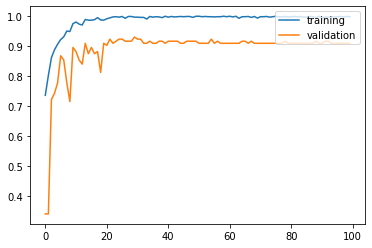

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'], loc='upper right')
plt.show()

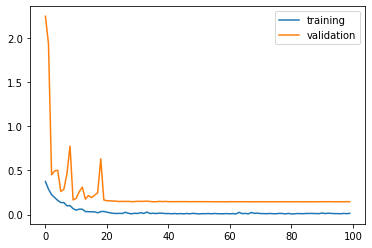

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'], loc='upper right')
plt.show()